In [1]:
## imports
import matplotlib.pyplot as plt

import pickle
from difflib import SequenceMatcher
import textdistance
import scipy
from collections import Counter, defaultdict
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics.pairwise import pairwise_distances

from scipy.cluster.hierarchy import dendrogram, linkage
import csv
import json

# Read csv file => reformat to json

In [2]:
reader = csv.DictReader(open('../GLDS_4_analysis.csv', 'r', encoding='utf-8-sig'), delimiter=';')
glds4 = []

In [3]:
for idx, line in enumerate(reader):
    gene_obj = dict(line)
    for key in ['FLT1', 'FLT2', 'FLT3', 'FLT4', 'AEM1', 'AEM2', 'AEM3', 'AEM4', 'flight1', 'flight2', 'flight3', 'flight4', 'control1', 'control2', 'control3', 'control4', 'flightMean', 'aemMean', 'FvsAEM']:
        gene_obj[key] = float(gene_obj[key].replace(',', '.'))
    glds4.append(gene_obj)
#    if idx > 0:
#        break

In [4]:
glds4[0]

{'Name': '0610007P14RIK',
 'Description': 'RIKEN cDNA 0610007P14 gene',
 'FLT1': 7.817609909,
 'FLT2': 8.259301845,
 'FLT3': 7.728688656,
 'FLT4': 8.227608089,
 'AEM1': 8.316221772,
 'AEM2': 8.254490447,
 'AEM3': 8.671204663,
 'AEM4': 8.596376001,
 'flight1': 0.075886102,
 'flight2': 0.023674024,
 'flight3': 0.086397417,
 'flight4': 0.027420519,
 'control1': -0.03844994,
 'control2': -0.030741525,
 'control3': -0.082776796,
 'control4': -0.073432911,
 'flightMean': 8.008303,
 'aemMean': 8.459574,
 'FvsAEM': -0.451271}

### Extract only description of genes

In [5]:
data = [i['Description'] for i in glds4]

# Calculated distance matrix and perform hierachical clustering

In [6]:
cluster_threshold = 0.96

In [7]:
%%time

# Custom distance metric and use editdistance.
def custom_distance(x, y):
    return textdistance.ratcliff_obershelp(
        data[int(x[0])],
        data[int(y[0])]
    )

# Reshape the data.
X = np.arange(len(data)).reshape(-1, 1)
print(X.shape)

# Calculate pairwise distances with the new metric.
m = pairwise_distances(X, X, metric=custom_distance, n_jobs=-1)
print('Done calculateting distances')

# Hierachical clustering
#upper_m = m[np.triu_indices(m.shape[0])]
#link_m = linkage(upper_m, method='single', metric=custom_distance)
link_m = linkage(m)
clss = scipy.cluster.hierarchy.fcluster(link_m, t=cluster_threshold, criterion='distance')
print(clss[:100])

# Pickle objest from multithreaded context, for use later
pickle.dump(clss, open('clss.pkl', 'wb'))
pickle.dump(m, open('m.pkl', 'wb'))


(1357, 1)
Done calculateting distances
[  4   4   4  11   4   4   4  10   4   4   4   4   4   4   4   4 863   4
   4   4   4   4   4   4   5   4   4   4   4   4   4   4   4   4   4   4
   4   7   4   4   4   4   4   4   4   4   4   8   4   4   4   4   4   4
   4   4   4   4   4   4   4   4   4   4   4   4   4   9   4   4   4  33
 175 141 536 301 301 301 301   2 396 726 513 313 126 126 849 210 211 856
 309 310  92 933 644 644 886 127 528 529]
CPU times: user 1.77 s, sys: 152 ms, total: 1.92 s
Wall time: 2min 2s


In [8]:
clss = pickle.load(open('clss.pkl', 'rb'))

In [9]:
print('No. of clusters: ', len(set(clss)))

No. of clusters:  994


In [10]:
Counter(clss).most_common(10)

[(4, 69),
 (30, 53),
 (12, 33),
 (376, 18),
 (214, 15),
 (180, 11),
 (519, 11),
 (674, 9),
 (66, 8),
 (25, 6)]

### Test the distance measure

In [11]:
print(textdistance.ratcliff_obershelp('adrenergic receptor kinase, beta 2', 'retinoic acid receptor, beta'))
print(textdistance.ratcliff_obershelp('adrenergic receptor kinase, beta 2', 'adrenergic receptor, beta 3'))
print(textdistance.ratcliff_obershelp('adrenergic receptor kinase, beta 2', 'retinoic acid induced 2'))


0.6451612903225806
0.8524590163934426
0.3508771929824561


### Inspect a class

In [12]:
for i in np.where(clss == 1)[0]:
    print(data[i])

selection and upkeep of intraepithelial T cells 2
selection and upkeep of intraepithelial T cells 3
selection and upkeep of intraepithelial T cells 4
selection and upkeep of intraepithelial T cells 9


NameError: name 'res' is not defined

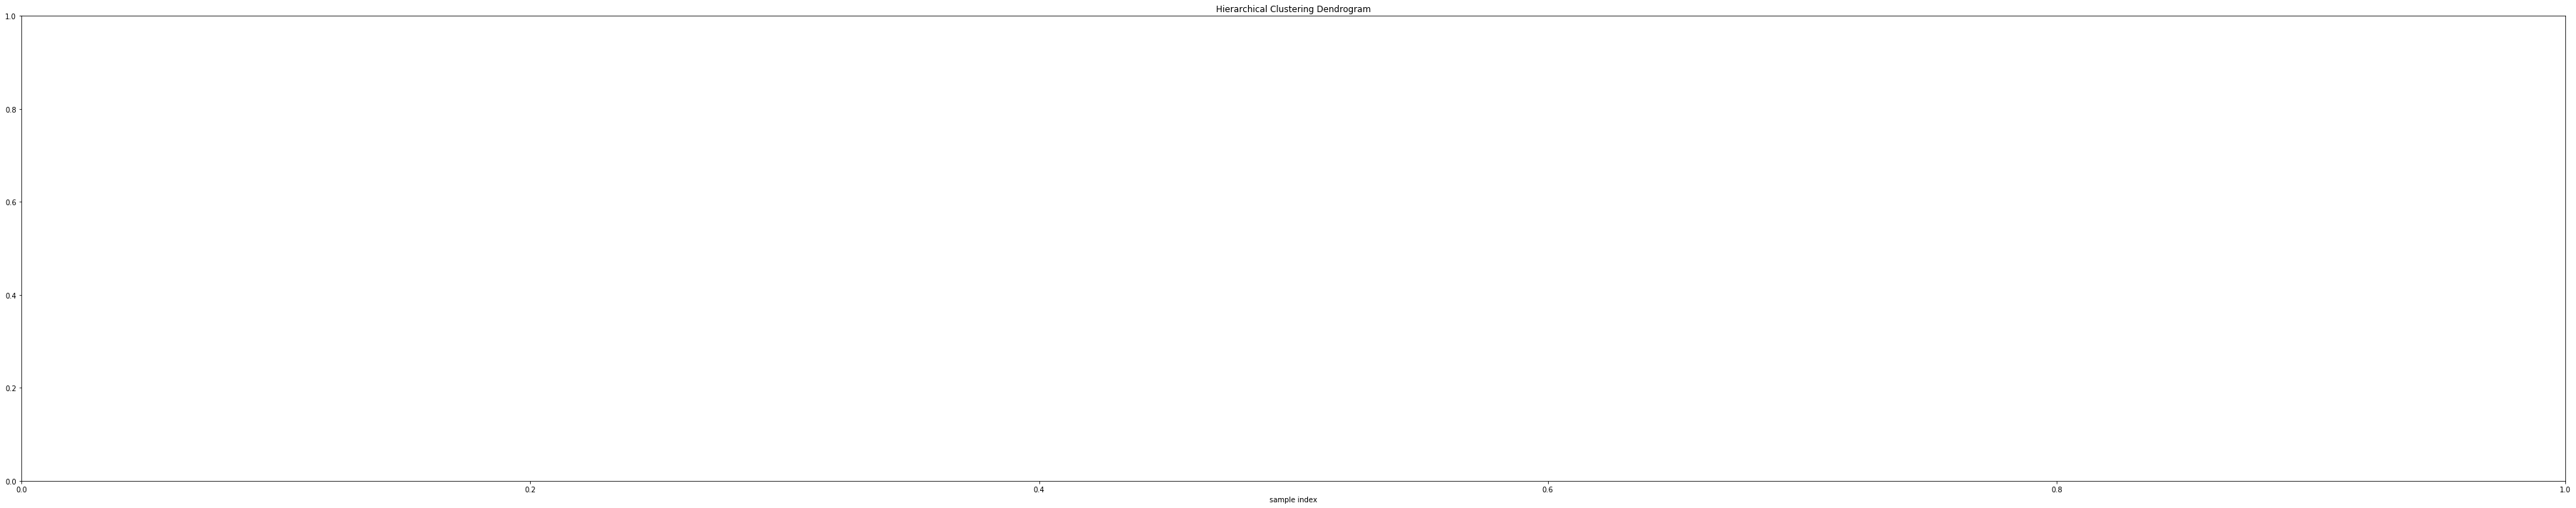

In [13]:
%%time
m = pickle.load(open('m.pkl', 'rb'))
plt.figure(figsize=(64, 12))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')

plt.yticks(np.arange(0, max(max([i for i in res['dcoord']])), 0.1))

plt.ylabel('distance')
# plt.yscale('log')
res = dendrogram(
    linkage(m),
    color_threshold=cluster_threshold
#    leaf_rotation=90.,  # rotates the x axis labels
#    leaf_font_size=8.,  # font size fora the x axis labels
)
pickle.dump(res, open('res.pkl', 'wb'))
plt.xticks(ticks=list(range(5, 10*len(data), 10)),labels=['{} ({})'.format(data[leave], leave) for leave in res['leaves']])
plt.savefig('dendogram.svg', bbox_inches='tight', pad_inches=.5)
plt.show()

In [14]:
res = pickle.load(open('res.pkl', 'rb'))

# Format as dict

In [15]:
clusters = defaultdict(list)

In [16]:
for cluster, gene in list(zip(clss, data)):
#    print(cluster, gene)
    clusters[cluster].append(gene)

In [17]:
clusters[750]

['"deubiquitinating enzyme 1 | ubiquitin specific peptidase, pseudogene (USP17 homolog) | deubiquitinating enzyme 3"']

In [18]:
def longestSubstring(str1,str2): 

    # initialize SequenceMatcher object with  
    # input string 
    seqMatch = SequenceMatcher(None,str1,str2) 

    # find match of longest sub-string 
    # output will be like Match(a=0, b=0, size=5) 
    match = seqMatch.find_longest_match(0, len(str1), 0, len(str2))

    # print longest substring 
    if (match.size!=0): 
        return (str1[match.a: match.a + match.size])  
    else: 
        print ('No longest common sub-string found') 
        return ''


# Get cluster name

In [19]:
from itertools import permutations 
  
# Get all permutations of [1, 2, 3] 
# Print the obtained permutations 
cluster_names = {}
for i in clusters.keys():
    cluster_name = ''
    if len(clusters[i]) == 1:
        cluster_name = clusters[i][0]
    for cluster_combi in list(permutations(clusters[i], 2)):
        lon_com = longestSubstring(*cluster_combi)
        if lon_com < cluster_name or cluster_name == '':
            cluster_name = lon_com
    cluster_names[i] = cluster_name

In [20]:
clusters[18]

['CD226 antigen']

In [21]:
cluster_names[18]

'CD226 antigen'

In [22]:
for gene, cls in zip(glds4, clss):
    gene['cluster'] = int(cls)
    gene['cluster_name'] = cluster_names[cls]

In [23]:
glds4[0]

{'Name': '0610007P14RIK',
 'Description': 'RIKEN cDNA 0610007P14 gene',
 'FLT1': 7.817609909,
 'FLT2': 8.259301845,
 'FLT3': 7.728688656,
 'FLT4': 8.227608089,
 'AEM1': 8.316221772,
 'AEM2': 8.254490447,
 'AEM3': 8.671204663,
 'AEM4': 8.596376001,
 'flight1': 0.075886102,
 'flight2': 0.023674024,
 'flight3': 0.086397417,
 'flight4': 0.027420519,
 'control1': -0.03844994,
 'control2': -0.030741525,
 'control3': -0.082776796,
 'control4': -0.073432911,
 'flightMean': 8.008303,
 'aemMean': 8.459574,
 'FvsAEM': -0.451271,
 'cluster': 4,
 'cluster_name': 'RIKEN cDNA '}

In [24]:
json.dump(glds4, open('glds4.json', 'w'))